In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score as roc_auc_score
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys
np.set_printoptions(threshold=sys.maxsize)
import collections
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
!pip install catboost
import catboost as cbst
from catboost import CatBoostClassifier,Pool, cv
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn import preprocessing
%matplotlib inline

In [0]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Table : Train 
### Customer id level feature coming from train+test

In [0]:
def customer_features_from_train_data():
  base_directory = "/content/drive/My Drive/personal_hackathons/DataSet/amex/train/cleaned_data/"
  # 6th Oct test_data= pd.read_csv(base_directory + "test.csv")
  train_data= pd.read_csv(base_directory + "train_data.csv")
  # 6th Oct train_data_drop = train_data.drop(['redemption_status'],axis=1)

  print("shape of train : {}".format(train_data_drop.shape))
  print("shape of train : {}".format(test_data.shape))
  all_data = train_data
  # 6th Oct train_data_drop.append(test_data)
  print("shape of train : {}".format(all_data.shape))
  # Total customer visits
  # combining campaign id and coupon id.
  # all_data['camp_coup'] = all_data['campaign_id'].astype(str)+"-"+ all_data['coupon_id'].astype(str)
  customer_visits = all_data.groupby(by='customer_id', as_index=False).agg({'id': pd.Series.nunique,
                                                                            'campaign_id' : pd.Series.nunique,
                                                                            'coupon_id' : pd.Series.nunique
                                                                            # ,'camp_coup': pd.Series.nunique
                                                                            ,'redemption_status' : pd.Series.sum
                                                                            })
  # dropped the feature number of redemptions, will created pseudo from discount.
  customer_visits = customer_visits.rename(columns={"customer_id":"customer_id",  "id": "num_visits","campaign_id": "num_campaign_targeted", "coupon_id": "num_coupons_posses"})
  customer_visits['visit_bins'] , bins = pd.qcut(customer_visits['num_visits'],q=10, retbins=True, labels=["b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9", "b10"])
  customer_visits['customer_redem_rate'] = customer_visits['redemption_status']/customer_visits['num_visits']
  customer_visits.head()
  min_max_scaler = preprocessing.MinMaxScaler()
  min_max_scaler.fit(customer_visits[['num_visits', 'num_campaign_targeted',
        'num_coupons_posses','customer_redem_rate']])
  customer_visits_scaled = min_max_scaler.transform(customer_visits[['num_visits', 'num_campaign_targeted',
        'num_coupons_posses','customer_redem_rate']])
  df_customer_visits_scaled = pd.DataFrame(customer_visits_scaled,columns=['num_visits', 'num_campaign_targeted',
        'num_coupons_posses','customer_redem_rate'])
  df_customer_visits_scaled[['customer_id','visit_bins']] = customer_visits[['customer_id','visit_bins']]
  df_customer_visits_scaled = df_customer_visits_scaled.drop(['visit_bins'],axis = 1)
  customer_visits = customer_visits.drop(['visit_bins'],axis = 1)
  return customer_visits, df_customer_visits_scaled, customer_visits.columns, df_customer_visits_scaled.columns
  # customer_visits.to_csv(base_directory + "customer_persona.csv",index=False)
  # df_customer_visits_scaled.to_csv(base_directory + "customer_persona_scaled.csv",index=False)

In [0]:
# base_directory = "/content/drive/My Drive/personal_hackathons/DataSet/amex/train/"
# # "/content/drive/My Drive/personal_hackathons/DataSet/amex/train/clean" is corrupted
# customer_transaction_data= pd.read_csv(base_directory + "customer_transaction_data.csv")
# customer_transaction_data.head()
# customer_transaction_data['psudo_redem']=0
# customer_transaction_data.loc[customer_transaction_data['coupon_discount']<0 ,'psudo_redem']=1
# customer_transaction_data.groupby(by='customer_id', as_index=False).agg({'psudo_redem': pd.Series.sum,
#                                                                           })
base_directory = "/content/drive/My Drive/personal_hackathons/AMEX/"
df= pd.read_csv(base_directory + "train_common_items_user_coupon.csv")
df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,common_items_user_coupon
0,1,13,27,1053,0,0
1,2,13,116,48,0,0
2,6,9,635,205,0,0
3,7,13,644,1050,0,0
4,9,8,1017,1489,0,0


In [0]:
def customer_transaction_features():
  base_directory = "/content/drive/My Drive/personal_hackathons/DataSet/amex/train/"
  # "/content/drive/My Drive/personal_hackathons/DataSet/amex/train/clean" is corrupted
  customer_transaction_data= pd.read_csv(base_directory + "customer_transaction_data.csv")
  customer_transaction_data['psudo_redem']=0
  customer_transaction_data.loc[customer_transaction_data['coupon_discount']<0 ,'psudo_redem']=1
  customer_transaction_data.head()
                          
  aggregation = {
      'selling_price' : {
          'tot_purchase':'sum',
          'avg_purchase':'mean',
          'max_purchase':'max'
      },
      'other_discount':{
          'tot_o_discount':'sum',
          'avg_o_discount':'mean',
          'max_o_discount':'min'
      },
      'coupon_discount':{
          'tot_c_discount':'sum',
          'avg_c_discount':'mean',
          'max_c_discount':'min'
      },
      'quantity':{
          'tot_qty':'sum',
          'avg_qty':'mean',
          'max_qty':'max'
      },
      'item_id' :{
          'uni_item':'nunique'
      }

  }
  # customer_trans_features = customer_transaction_data.groupby(by='customer_id', as_index=False).agg(aggregation)
  customer_trans_features = customer_transaction_data.groupby(by='customer_id').agg(aggregation)
  # Using ravel, and a string join, we can create better names for the columns:
  customer_trans_features.columns = ["_".join(x) for x in customer_trans_features.columns.ravel()]
  customer_trans_features.head()
  # print(len(customer_transaction_data['customer_id'].unique()))
  from sklearn import preprocessing
  min_max_scaler = preprocessing.MinMaxScaler()
  min_max_scaler.fit(customer_trans_features)
  customer_trans_features_scaled = min_max_scaler.transform(customer_trans_features)
  df_customer_trans_features_scaled = pd.DataFrame(customer_trans_features_scaled,columns=customer_trans_features.columns)
  df_customer_trans_features_scaled.head()

  for f in customer_trans_features.columns:
    print(f)
    try:
      customer_trans_features[f+"_bin"], bins = pd.qcut(customer_trans_features[f], q=10, retbins=True,labels=["b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9", "b10"])
    except:
      customer_trans_features[f+"_bin"], bins = pd.qcut(customer_trans_features[f], q=3, retbins=True,labels=["b1", "b2","b3"])


  customer_trans_features.reset_index(level=0, inplace=True)
  # customer_trans_features.reset_index(level=0, inplace=True)
  # df_customer_trans_features_scaled.columns = ["_".join(x) for x in df_customer_trans_features_scaled.columns]
  df_customer_trans_features_scaled.columns = [s + "_scld" for s in df_customer_trans_features_scaled.columns]
  df_customer_trans_features_scaled['customer_id'] = customer_trans_features['customer_id']
  df_customer_trans_features_scaled.head()

  # df_customer_trans_features_scaled.to_csv(base_directory + "customer_purchase_power_scaled.csv",index=False)
  # customer_trans_features.to_csv(base_directory + "customer_purchase_power.csv",index=False)
  # customer_trans_features.shape, df_customer_trans_features_scaled.shape

  customer_psudo_redem = customer_transaction_data.groupby(by='customer_id', as_index=False).agg({'psudo_redem': pd.Series.sum                                                                      
                                                                            })
  # persona_purachase_power = pd.merge(df_customer_trans_features_scaled,df_customer_visits_scaled,on='customer_id', how='left')
  # persona_purachase_power = pd.merge(customer_trans_features,customer_visits,on='customer_id', how='left')
  persona_purachase_power_psudo = pd.merge(customer_trans_features,customer_psudo_redem,on='customer_id', how='left')
  # persona_purachase_power_psudo_1 = pd.merge(persona_purachase_power_psudo,customer_trans_features,on='customer_id', how='left')
  print (persona_purachase_power_psudo.columns)
  feature_set = ['customer_id', 'selling_price_tot_purchase',
       'selling_price_avg_purchase', 'selling_price_max_purchase',
       'other_discount_tot_o_discount', 'other_discount_avg_o_discount',
       'other_discount_max_o_discount', 'coupon_discount_tot_c_discount',
       'coupon_discount_avg_c_discount', 'coupon_discount_max_c_discount',
       'quantity_tot_qty', 'quantity_avg_qty', 'quantity_max_qty',
       'item_id_uni_item','psudo_redem']
  return persona_purachase_power_psudo[feature_set]

In [0]:
df = customer_transaction_features()

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


selling_price_tot_purchase
selling_price_avg_purchase
selling_price_max_purchase
other_discount_tot_o_discount
other_discount_avg_o_discount
other_discount_max_o_discount
coupon_discount_tot_c_discount
coupon_discount_avg_c_discount
coupon_discount_max_c_discount
quantity_tot_qty
quantity_avg_qty
quantity_max_qty
item_id_uni_item
Index(['customer_id', 'selling_price_tot_purchase',
       'selling_price_avg_purchase', 'selling_price_max_purchase',
       'other_discount_tot_o_discount', 'other_discount_avg_o_discount',
       'other_discount_max_o_discount', 'coupon_discount_tot_c_discount',
       'coupon_discount_avg_c_discount', 'coupon_discount_max_c_discount',
       'quantity_tot_qty', 'quantity_avg_qty', 'quantity_max_qty',
       'item_id_uni_item', 'selling_price_tot_purchase_bin',
       'selling_price_avg_purchase_bin', 'selling_price_max_purchase_bin',
       'other_discount_tot_o_discount_bin',
       'other_discount_avg_o_discount_bin',
       'other_discount_max_o_discoun

### Number of items sold in the coupon
### Coupon redemption rate

In [0]:
def coupon_item_count_redem_rate():
  base_directory = "/content/drive/My Drive/personal_hackathons/DataSet/amex/train/"
  # "/content/drive/My Drive/personal_hackathons/DataSet/amex/train/clean" is corrupted
  coupon_item_mapping= pd.read_csv(base_directory + "coupon_item_mapping.csv")
                          
  aggregation = {
      'item_id' : {
          'tot_item_in_coupon':'nunique',
      }
  }
  # customer_trans_features = customer_transaction_data.groupby(by='customer_id', as_index=False).agg(aggregation)
  coupon_item_mapping_features = coupon_item_mapping.groupby(by='coupon_id').agg(aggregation)
  coupon_item_mapping_features.columns = [x[1] for x in coupon_item_mapping_features.columns.ravel()]

  coupon_item_mapping_features.reset_index(level=0, inplace=True)
  train_data.head()


  aggregation_redem_rate = {
      'redemption_status' : {
          'c_sum':'sum',
          'c_count':'count'
      }
  }
  coupon_redem_rate_features = train_data.groupby(by='coupon_id').agg(aggregation_redem_rate)
  coupon_redem_rate_features.columns = [x[1] for x in coupon_redem_rate_features.columns.ravel()]
  coupon_redem_rate_features['coupon_redemption_rate'] = coupon_redem_rate_features['c_sum']*100/coupon_redem_rate_features['c_count']
  coupon_redem_rate_features.reset_index(level=0, inplace=True)
  coupon_redem_rate_features.head()
  # df_customer_trans_features_scaled.to_csv(base_directory + "customer_purchase_power_scaled.csv",index=False)
  # customer_trans_features.to_csv(base_directory + "customer_purchase_power.csv",index=False)

  ## Getting coupon redemption rate to item coupon mapping then getting 

  coupon_item_mapping_rate = pd.merge(coupon_item_mapping, coupon_redem_rate_features[['coupon_id','coupon_redemption_rate']],on='coupon_id', how='left')
  coupon_item_mapping_rate.fillna(0, inplace=True)
  coupon_price_data= pd.read_csv("/content/drive/My Drive/personal_hackathons/AMEX/coupon_price_data.csv") 

  # item_data= pd.read_csv(base_directory + "item_data.csv")
  # coupon_rate_grosary = pd.merge(coupon_item_mapping_rate, item_data,on='item_id', how='left')
  # coupon_rate_grosary.head()
  coupon_features = pd.merge(coupon_item_mapping_features, coupon_redem_rate_features[['coupon_id','coupon_redemption_rate']],on='coupon_id', how='left')
  coupon_features = pd.merge(coupon_features, coupon_price_data,on='coupon_id', how='left')
  coupon_features.head()
  return coupon_features

In [0]:
coupon_features = coupon_item_count_redem_rate()
coupon_features.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,coupon_id,tot_item_in_coupon,coupon_redemption_rate,median_mrp,std_mean_mrp,std_mrp
0,1,39,0.0,111.8450,25.065998,3.208026e+00
1,2,2,0.0,122.5345,17.628879,1.959506e-03
2,3,17,0.0,135.0000,6.697936,9.440213e+00
3,4,24,0.0,213.3600,14.251253,2.798186e+00
4,5,7,0.0,320.2200,137.784172,4.236858e-14


In [0]:
coupon_rate_grosary.head()
category_redem_rate = pd.pivot_table(coupon_rate_grosary,index=["item_id"],values=["coupon_redemption_rate"],
               columns=["category"],aggfunc=[np.mean])

category_redem_rate.columns = ['_'.join(x) for x in category_redem_rate.columns.ravel()]
category_redem_rate.fillna(0, inplace=True)
category_redem_rate.head()
category_redem_rate.reset_index(level=0, inplace=True)

customer_transaction_data.head()
category_redem_rate = pd.merge(category_redem_rate,customer_transaction_data,on='item_id', how='left')
category_redem_rate.head()

,item_id,mean_coupon_redemption_rate_Bakery,"mean_coupon_redemption_rate_Dairy, Juices & Snacks",mean_coupon_redemption_rate_Flowers & Plants,mean_coupon_redemption_rate_Garden,mean_coupon_redemption_rate_Grocery,mean_coupon_redemption_rate_Meat,mean_coupon_redemption_rate_Miscellaneous,mean_coupon_redemption_rate_Natural Products,mean_coupon_redemption_rate_Packaged Meat,mean_coupon_redemption_rate_Pharmaceutical,mean_coupon_redemption_rate_Prepared Food,mean_coupon_redemption_rate_Restauarant,mean_coupon_redemption_rate_Salads,mean_coupon_redemption_rate_Seafood,mean_coupon_redemption_rate_Skin & Hair Care,mean_coupon_redemption_rate_Travel,mean_coupon_redemption_rate_Vegetables (cut),date,customer_id,quantity,selling_price,other_discount,coupon_discount,psudo_redem
0,1,0.0,0.0,0.0,0.0,4.508197,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-06-06,781.0,1.0,124.31,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,4.508197,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-09-04,230.0,1.0,124.31,0.0,0.0,0.0
2,4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-08-26,890.0,1.0,54.85,0.0,0.0,0.0
3,7,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.03252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-06-17,637.0,1.0,270.36,0.0,0.0,0.0
4,10,0.0,0.0,0.0,0.0,2.911993,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-03-12,637.0,1.0,97.96,0.0,0.0,0.0


# Building the data for training

### reading train test

In [0]:
base_directory = "/content/drive/My Drive/personal_hackathons/DataSet/amex/train/cleaned_data/"
test_data= pd.read_csv(base_directory + "test.csv")
train_data= pd.read_csv(base_directory + "train_data.csv")

### reading campaign data features
join condition : campaign id

features prepared: ?
pranshu has created them and his code writes them into file campaign_data_with_only_new_features

In [0]:
base_directory = "/content/drive/My Drive/personal_hackathons/DataSet/amex/train/cleaned_data/campaign_data_features/"
campaign_level_data= pd.read_csv(base_directory + "campaign_data_features.csv")

Now including campaign data features in training data by left join with train data

In [0]:
X_train = train_data.drop(['redemption_status'],axis=1)
y_train = train_data.loc[:, train_data.columns == 'redemption_status']
X_test = test_data.loc[:, test_data.columns != 'redemption_status']

# campaign trends
X_train = pd.merge(X_train,campaign_level_data,on='campaign_id', how='left')
X_test = pd.merge(X_test,campaign_level_data,on='campaign_id', how='left')

### Creating customer id level features from train


In [0]:
customer_visits, customer_visit_scaled, customer_visits_features, customer_visit_scaled_features = customer_features_from_train_data()
customer_visits_features

shape of train : (78369, 4)
shape of train : (50226, 4)
shape of train : (78369, 5)


Index(['customer_id', 'num_visits', 'num_campaign_targeted',
       'num_coupons_posses', 'redemption_status', 'customer_redem_rate'],
      dtype='object')

Now including customer visits features into train test

In [0]:
# campaign trends
X_train = pd.merge(X_train,customer_visits,on='customer_id', how='left')
X_test = pd.merge(X_test,customer_visits,on='customer_id', how='left')

X_train[customer_visits_features].fillna(0, inplace=True)
X_test[customer_visits_features].fillna(0, inplace=True) 


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


### Including Customer Coupons common number of items

In [0]:
ba_dir = "/content/drive/My Drive/personal_hackathons/AMEX/"
train_common_items_user_coupon= pd.read_csv(ba_dir + "train_common_items_user_coupon.csv")
test_common_items_user_coupon= pd.read_csv(ba_dir + "test_common_items_user_coupon.csv")
test_common_items_user_coupon.head()

# customer persona, customer purchase power.
X_train = pd.merge(X_train,train_common_items_user_coupon[['id','common_items_user_coupon']],on='id', how='left')
X_test = pd.merge(X_test,test_common_items_user_coupon[['id','common_items_user_coupon']],on='id', how='left')

### Creating customer id level features from customer transactions

In [0]:
persona_purachase_power_psudo = customer_transaction_features()

# customer persona, customer purchase power.
X_train = pd.merge(X_train,persona_purachase_power_psudo,on='customer_id', how='left')
X_test = pd.merge(X_test,persona_purachase_power_psudo,on='customer_id', how='left')

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True) 

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


selling_price_tot_purchase
selling_price_avg_purchase
selling_price_max_purchase
other_discount_tot_o_discount
other_discount_avg_o_discount
other_discount_max_o_discount
coupon_discount_tot_c_discount
coupon_discount_avg_c_discount
coupon_discount_max_c_discount
quantity_tot_qty
quantity_avg_qty
quantity_max_qty
item_id_uni_item
Index(['customer_id', 'selling_price_tot_purchase',
       'selling_price_avg_purchase', 'selling_price_max_purchase',
       'other_discount_tot_o_discount', 'other_discount_avg_o_discount',
       'other_discount_max_o_discount', 'coupon_discount_tot_c_discount',
       'coupon_discount_avg_c_discount', 'coupon_discount_max_c_discount',
       'quantity_tot_qty', 'quantity_avg_qty', 'quantity_max_qty',
       'item_id_uni_item', 'selling_price_tot_purchase_bin',
       'selling_price_avg_purchase_bin', 'selling_price_max_purchase_bin',
       'other_discount_tot_o_discount_bin',
       'other_discount_avg_o_discount_bin',
       'other_discount_max_o_discoun

### Adding coupon num items, redemption rate and mrp's

In [0]:
coupon_features = coupon_item_count_redem_rate()

# customer persona, customer purchase power.
X_train = pd.merge(X_train,coupon_features,on='coupon_id', how='left')
X_test = pd.merge(X_test,coupon_features,on='coupon_id', how='left')

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True) 






/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


## customer campaign level features during the time duration of campaign.

In [0]:
base_directory = "/content/drive/My Drive/personal_hackathons/DataSet/amex/train/cleaned_data/campaign_customer_features/"
transac_till_start_cust_camp= pd.read_csv(base_directory + "transactions_by_customer_till_campaign_start_features.csv")
transac_during_start_cust_camp= pd.read_csv(base_directory + "transactions_by_customer_during_similar_period_as_campaign_features_in_history.csv")

# customer persona, customer purchase power.
X_train = pd.merge(X_train,transac_till_start_cust_camp,on=['campaign_id','customer_id'], how='left')
X_train = pd.merge(X_train,transac_during_start_cust_camp,on=['campaign_id','customer_id'], how='left')

X_train.fillna(0, inplace=True)

X_test = pd.merge(X_test,transac_till_start_cust_camp,on=['campaign_id','customer_id'], how='left')
X_test = pd.merge(X_test,transac_during_start_cust_camp,on=['campaign_id','customer_id'], how='left')

X_test.fillna(0, inplace=True) 




## coupon customer intersection based more features

In [0]:
base_directory1 = "/content/drive/My Drive/personal_hackathons/DataSet/amex/train/cleaned_data/customer_coupon_intersection_features/"
customer_coupon_intersection_features= pd.read_csv(base_directory1 + "customer_coupon_intersection_features_1.csv")
customer_coupon_intersection_features.drop_duplicates()
print (X_train.shape, X_test.shape)
# customer persona, customer purchase power.
X_train = pd.merge(X_train,customer_coupon_intersection_features,on=['coupon_id','customer_id'], how='left')
X_test = pd.merge(X_test,customer_coupon_intersection_features,on=['coupon_id','customer_id'], how='left')

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
print (X_train.shape, X_test.shape)



(78369, 63) (50226, 63)
(78369, 69) (50226, 69)


### brand type bent features

In [0]:
base_directory1 = "/content/drive/My Drive/personal_hackathons/DataSet/amex/train/cleaned_data/brand_type_bent_features/"

customer_brand_type_preference_features= pd.read_csv(base_directory1 + "customer_brand_type_preference_features.csv")

print (X_train.shape, X_test.shape)
X_train = pd.merge(X_train,customer_brand_type_preference_features,on=['customer_id'], how='left')
X_test = pd.merge(X_test,customer_brand_type_preference_features,on=['customer_id'], how='left')



coupon_brand_type_bent_features= pd.read_csv(base_directory1 + "coupon_brand_type_bent_features_1.csv")
X_train = pd.merge(X_train,coupon_brand_type_bent_features,on=['coupon_id'], how='left')
X_test = pd.merge(X_test,coupon_brand_type_bent_features,on=['coupon_id'], how='left')

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
print (X_train.shape, X_test.shape)

(78369, 69) (50226, 69)
(78369, 71) (50226, 71)


### Including Customer Coupons common number of items with only discounted

In [0]:
ba_dir = "/content/drive/My Drive/personal_hackathons/AMEX/"
features_to_be_picked = ['id', 'common_items_with_disc', 'common_items_with_disc_ratio']

train_common_items_user_coupon= pd.read_csv(ba_dir + "train_coupon_consumer_price_data_1.csv")
test_common_items_user_coupon= pd.read_csv(ba_dir + "test_coupon_consumer_price_data_1.csv")

# customer persona, customer purchase power.
X_train = pd.merge(X_train,train_common_items_user_coupon[features_to_be_picked],on='id', how='left')
X_test = pd.merge(X_test,test_common_items_user_coupon[features_to_be_picked],on='id', how='left')
# test_common_items_user_coupon.shape, train_common_items_user_coupon.shape

# X_train.fillna(0, inplace=True)
# X_test.fillna(0, inplace=True)
print (X_train.shape, X_test.shape)


(78369, 73) (50226, 73)



## coupon redemption customer redemption till date

In [0]:
base_directory1 = "/content/drive/My Drive/personal_hackathons/DataSet/amex/train/cleaned_data/pranshu_features/"

campaign_coupon_redemption_record_feature= pd.read_csv(base_directory1 + "campaign_coupon_redemption_record_feature.csv")

print (X_train.shape, X_test.shape)
X_train = pd.merge(X_train,campaign_coupon_redemption_record_feature,on=['campaign_id', 'coupon_id'], how='left')
X_test = pd.merge(X_test,campaign_coupon_redemption_record_feature,on=['campaign_id', 'coupon_id'], how='left')



customer_redemption_record_till_campaign_start_feature= pd.read_csv(base_directory1 + "customer_redemption_record_till_campaign_start_feature.csv")
X_train = pd.merge(X_train,customer_redemption_record_till_campaign_start_feature,on=['campaign_id', 'customer_id'], how='left')
X_test = pd.merge(X_test,customer_redemption_record_till_campaign_start_feature,on=['campaign_id', 'customer_id'], how='left')

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
print (X_train.shape, X_test.shape)

identifier_columns = ['id','campaign_id','coupon_id','customer_id']
# id dropping
X_train = X_train.drop(identifier_columns,axis=1)
X_test = X_test.drop(identifier_columns,axis=1)

(78369, 73) (50226, 73)
(78369, 75) (50226, 75)


### Dropping high correlated features

In [0]:
# ## Dropping correlated features
# # Create correlation matrix
# corr_matrix = X_train[numerical_features].corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.8
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# to_drop
# X_train = X_train.drop(X_train[to_drop], axis=1)
# X_test = X_test.drop(X_test[to_drop], axis=1)

In [0]:
# base_directory_high = "/content/drive/My Drive/personal_hackathons/AMEX/high_auc_features/"
# X_train.to_csv(base_directory_high + "x_train.csv",index=False)
# X_test.to_csv(base_directory_high + "x_test.csv",index=False)
# y_train.to_csv(base_directory_high + "y_train.csv",index=False)

In [0]:
y_train.shape

(78369, 1)

In [0]:
X_test.head()

,duration_in_days,same_type_overlapping_campaigns,other_type_overlapping_campaigns,same_type_overlap_duration,other_type_overlap_duration,number_of_weekends,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,campaign_type_X,campaign_type_Y,num_visits,num_campaign_targeted,num_coupons_posses,redemption_status,customer_redem_rate,common_items_user_coupon,selling_price_tot_purchase,selling_price_avg_purchase,selling_price_max_purchase,other_discount_tot_o_discount,other_discount_avg_o_discount,other_discount_max_o_discount,coupon_discount_tot_c_discount,coupon_discount_avg_c_discount,coupon_discount_max_c_discount,quantity_tot_qty,quantity_avg_qty,quantity_max_qty,item_id_uni_item,psudo_redem,tot_item_in_coupon,coupon_redemption_rate,median_mrp,std_mean_mrp,std_mrp,no_of_transactions_by_customer_till_campaign_start,percentage_of_transactions_by_customer_till_campaign_start_with_any_discount,percentage_of_transactions_by_customer_till_campaign_start_with_coupon_discount,transaction_amount_by_customer_till_campaign_start,transaction_amount_by_customer_till_campaign_start_where_customer_got_any_discount,transaction_amount_by_customer_till_campaign_start_where_customer_got_coupon_discount,average_percent_discount_by_customer_till_campaign_start,no_of_transactions_by_customer_for_similar_period,percentage_of_transactions_by_customer_for_similar_period_with_any_discount,percentage_of_transactions_by_customer_for_similar_period_with_coupon_discount,transaction_amount_by_customer_for_similar_period,transaction_amount_by_customer_for_similar_period_where_customer_got_any_discount,transaction_amount_by_customer_for_similar_period_where_customer_got_coupon_discount,average_percent_discount_by_customer_for_similar_period,no_of_item_ids_purchased_by_customer_and_covered_by_coupon,no_of_brands_purchased_by_customer_and_covered_by_coupon,no_of_categories_purchased_by_customer_and_covered_by_coupon,percent_of_item_ids_purchased_by_customer_and_covered_by_coupon,percent_of_brands_purchased_by_customer_and_covered_by_coupon,percent_of_categories_purchased_by_customer_and_covered_by_coupon
0,33,1,4,19,33,8,0,0,0,0,0,0,0,0,1,1,0,0,1.0,0.0,77.0,5.0,71.0,3.0,0.038961,7,156733.77,115.076189,1558.73,-16292.99,-11.962548,-160.29,-2111.86,-1.550558,-89.05,16644,12.220264,15095,658,81,72,0.000000,0.0000,0.000000,0.000000,1362.0,0.472834,0.059471,175138.62,87679.28,15134.82,-0.104584,125.0,0.512000,0.016000,17113.17,9810.43,1156.93,-0.105957,7.0,1.0,1.0,0.001520,0.004695,0.076923
1,71,5,2,71,42,21,0,0,0,0,0,0,0,0,1,1,1,0,0.0,1.0,54.0,5.0,54.0,0.0,0.000000,2,297070.87,111.638809,3561.29,-32760.94,-12.311514,-160.29,-1489.97,-0.559929,-177.39,282396,106.124014,21222,1214,31,33,0.000000,177.7405,63.444772,9.342242,2661.0,0.429538,0.011650,331321.78,173368.07,7958.54,-0.099968,535.0,0.442991,0.001869,58819.71,29357.38,622.99,-0.089495,2.0,1.0,1.0,0.000824,0.003413,0.066667
2,33,1,4,19,33,8,0,0,0,0,0,0,0,0,1,1,0,0,1.0,0.0,112.0,6.0,109.0,7.0,0.062500,0,161811.27,98.545231,1459.71,-39450.39,-24.025816,-583.81,-2384.75,-1.452345,-178.10,181500,110.535932,10532,1019,56,19,2.884615,95.8100,20.638556,6.125467,1642.0,0.549330,0.034105,203646.41,138942.35,12648.98,-0.164874,67.0,0.522388,0.074627,9029.77,6320.43,1045.79,-0.158437,0.0,0.0,1.0,0.000000,0.000000,0.090909
3,33,3,0,33,0,8,0,0,0,0,0,0,0,0,0,1,1,0,0.0,1.0,52.0,3.0,52.0,0.0,0.000000,0,49149.16,85.775148,1638.16,-7705.95,-13.448429,-356.20,0.00,0.000000,0.00,22196,38.736475,5003,323,0,74,0.000000,0.0000,0.000000,0.000000,573.0,0.443281,0.000000,56855.11,28923.01,0.00,-0.119744,21.0,0.142857,0.000000,1597.17,333.75,0.00,-0.033433,0.0,0.0,1.0,0.000000,0.000000,0.125000
4,33,2,1,24,21,8,0,0,0,0,0,0,1,1,0,0,0,0,0.0,1.0,33.0,2.0,33.0,0.0,0.000000,0,117044.09,88.736990,1281.96,-19214.01,-14.567104,-400.37,-89.04,-0.067506,-35.62,1729,1.310842,20,720,3,18,0.000000,0.0000,0.000000,0.000000,1319.0,0.450341,0.002274,136347.14,74048.81,617.64,-0.108141,79.0,0.455696,0.000000,6125.54,3659.59,0.00,-0.098625,0.0,1.0,1.0,0.00138

In [0]:

# # coupons item counts
# X_train = pd.merge(X_train,coupon_item_mapping_features,on='coupon_id', how='left')
# X_test = pd.merge(X_test,coupon_item_mapping_features,on='coupon_id', how='left')

# # coupon redem rate
# X_train = pd.merge(X_train, coupon_redem_rate_features[['coupon_id','coupon_redemption_rate']],on='coupon_id', how='left')
# X_test = pd.merge(X_test,coupon_redem_rate_features[['coupon_id','coupon_redemption_rate']],on='coupon_id', how='left')
# identifier_columns = ['id','campaign_id','coupon_id','customer_id','visit_bins']
# # id dropping
# X_train = X_train.drop(identifier_columns,axis=1)
# X_test = X_test.drop(identifier_columns,axis=1)
# numerical_features = ['selling_price_tot_purchase', 'selling_price_avg_purchase','selling_price_max_purchase', 'other_discount_tot_o_discount','other_discount_avg_o_discount', 'other_discount_max_o_discount',
#                       'coupon_discount_tot_c_discount', 'coupon_discount_avg_c_discount','coupon_discount_max_c_discount', 'quantity_tot_qty',
#                       'quantity_avg_qty', 'quantity_max_qty', 'item_id_uni_item',
#                       'num_visits', 'num_campaign_targeted', 'num_coupons_posses',
#                       'psudo_redem', 'duration_in_days', 'same_type_overlapping_campaigns',
#                       'other_type_overlapping_campaigns', 'same_type_overlap_duration',
#                       'other_type_overlap_duration', 'number_of_weekends', 'Jan', 'Feb',
#                       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec','campaign_type_X', 'campaign_type_Y',
#                       'tot_item_in_coupon', 'coupon_redemption_rate']
#        # What is prob?
# categorical_features =  ['selling_price_tot_purchase_bin', 'selling_price_avg_purchase_bin',
#                 'selling_price_max_purchase_bin', 'other_discount_tot_o_discount_bin',
#                 'other_discount_avg_o_discount_bin',
#                 'other_discount_max_o_discount_bin',
#                 'coupon_discount_tot_c_discount_bin',
#                 'coupon_discount_avg_c_discount_bin','coupon_discount_max_c_discount_bin', 'quantity_tot_qty_bin',
#                'quantity_avg_qty_bin', 'quantity_max_qty_bin', 'item_id_uni_item_bin']
# X_train[numerical_features].fillna(0, inplace=True)
# X_test[numerical_features].fillna(0, inplace=True) 
# X_train[categorical_features].fillna('b1', inplace =True)
# X_train[categorical_features].fillna('b1', inplace =True)
# X_train.head()
# X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split( X_train, y_train, test_size=0.33, random_state=42, stratify=y_train)
# ## Dropping correlated features
# # Create correlation matrix
# corr_matrix = X_train[numerical_features].corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.8
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# to_drop
# X_train = X_train.drop(X_train[to_drop], axis=1)
# X_test = X_test.drop(X_test[to_drop], axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [0]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# ['selling_price_tot_purchase', 'selling_price_avg_purchase',
#        'selling_price_max_purchase', 'other_discount_avg_o_discount',
#        'other_discount_max_o_discount', 'quantity_tot_qty', 'quantity_avg_qty',
#        'selling_price_tot_purchase_bin', 'selling_price_avg_purchase_bin',
#        'selling_price_max_purchase_bin', 'other_discount_tot_o_discount_bin',
#        'other_discount_avg_o_discount_bin',
#        'other_discount_max_o_discount_bin', 'quantity_tot_qty_bin',
#        'quantity_avg_qty_bin', 'quantity_max_qty_bin', 'item_id_uni_item_bin',
#        'num_visits', 'duration_in_days', 'same_type_overlapping_campaigns',
#        'other_type_overlapping_campaigns', 'same_type_overlap_duration', 'Jan',
#        'Feb', 'May', 'Oct', 'Nov']
# min_max_scaler.fit(X_train.append(X_test))
X_train.columns

Index(['duration_in_days', 'same_type_overlapping_campaigns',
       'other_type_overlapping_campaigns', 'same_type_overlap_duration',
       'other_type_overlap_duration', 'number_of_weekends', 'Jan', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
       'campaign_type_X', 'campaign_type_Y', 'num_visits_x',
       'num_campaign_targeted_x', 'num_coupons_posses_x',
       'redemption_status_x', 'customer_redem_rate_x',
       'common_items_user_coupon', 'selling_price_tot_purchase',
       'selling_price_avg_purchase', 'selling_price_max_purchase',
       'other_discount_tot_o_discount', 'other_discount_avg_o_discount',
       'other_discount_max_o_discount', 'coupon_discount_tot_c_discount',
       'coupon_discount_avg_c_discount', 'coupon_discount_max_c_discount',
       'quantity_tot_qty', 'quantity_avg_qty', 'quantity_max_qty',
       'item_id_uni_item', 'selling_price_tot_purchase_bin',
       'selling_price_avg_purchase_bin', 'selling_price_ma

In [0]:
X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split( X_train, y_train, test_size=0.33, random_state=42, stratify=y_train)
# ## Dropping correlated features

In [0]:
# ## Dropping correlated features
# # Create correlation matrix
# corr_matrix = X_train.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.8
# to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
# # to_drop
# num_train = num_train.drop(num_train[to_drop], axis=1)
# num_test = num_test.drop(num_test[to_drop], axis=1)

In [0]:
preds_tr = np.zeros((len(X_tr_train), 1))
preds = np.zeros((len(X_tr_test), 1))
for i in range(7):
    print("training LGBC model {}".format(i))
    lgbc = lgb.LGBMClassifier(n_estimators=3500, max_depth=7, learning_rate=0.001, random_state=i, colsample_bytree=0.5, reg_lambda=15, reg_alpha=10)
    lgbc.fit(X_tr_train, y_tr_train)
    preds_tr = preds_tr + lgbc.predict_proba(X_tr_train)[:,1].reshape(-1, 1)
    preds = preds + lgbc.predict_proba(X_tr_test)[:,1].reshape(-1, 1)
preds_tr = preds_tr/7
preds = preds/7

training LGBC model 0


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training LGBC model 1
training LGBC model 2
training LGBC model 3
training LGBC model 4
training LGBC model 5
training LGBC model 6


In [0]:
# Train AUC and Validation AUC
roc_auc_score(y_tr_train, preds_tr), roc_auc_score(y_tr_test, preds)

(0.9989770643387237, 0.9983705988069629)

first try : (0.9320700601514138, 0.8826245683771141)

second try : ((0.9098739615632245, 0.8819773263665811)

third try : ((0.9188230876549205, 0.8847230641487848))

fourth try : (0.9391805610749413, 0.8861403889217562))

fifth try : (0.918460318250677, 0.8795682872306674))

added tot items in a coupon and coupon redemption rate.

sixth try : (0.9617636754098992, 0.9527717392096506)

just campaign features : (0.7719987597532932, 0.7367990728559836)

after adding customer level features from train data
(0.9450772085483267, 0.9386069939710051) -- checking submission 0.79

after adding coupon customer common items
(0.990913491098303, 0.9887642414700986) -- checking submission 0.85

(0.9946873525719954, 0.9921262883905693) -- LB 0.891

(0.9947858545695316, 0.992139730424067) -- LB 0.887 after adding pranshu features

(0.9952876809828943, 0.9931946061492283) -- LB 0.8989

(0.9952232538615304, 0.9933125073587037) remove pranshu features increal colspace

(0.9952965837829115, 0.9934718683341481) increase colspace to 0.90 - LB : 0.8971

(0.996323734486674, 0.993856828739262) num of estimators increased to 2900 LB: 0.901

(0.9964822515984859, 0.9940731968929145)
after adding customer coupon features
LB : 0.90365

making estimators to 3900: 0.9027

making estimators to 3000: (0.9965311382127401, 0.9941110937102458)

brand type bent features: (0.9965010814144517, 0.9941745789768863) LB - 0.9046

(0.9989770643387237, 0.9983705988069629) LB - 0.9155

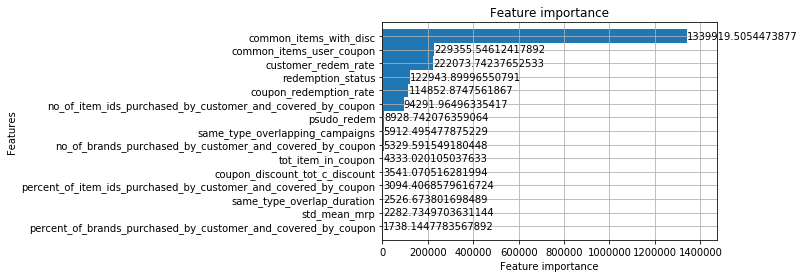

In [0]:
lgb.plot_importance(lgbc, importance_type="gain",height= 1,max_num_features=15)

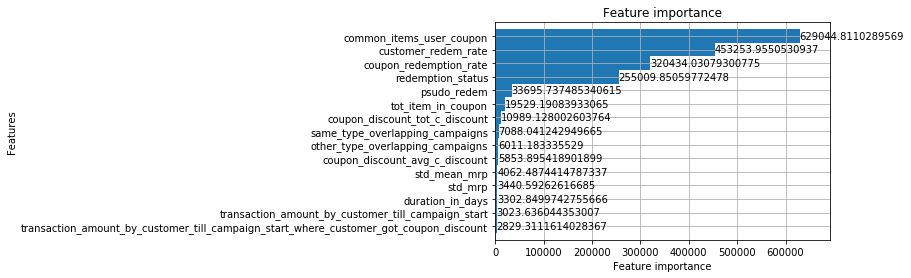

In [0]:
lgb.plot_importance(lgbc, importance_type="gain",height= 1,max_num_features=15)

In [0]:
preds_tr = np.zeros((len(X_train), 1))
preds = np.zeros((len(X_test), 1))
for i in range(7):
    print("training LGBC model {}".format(i))
    #LB:0.8989 13 lgbc = lgb.LGBMClassifier(n_estimators=500, max_depth=7, learning_rate=0.001, random_state=i, colsample_bytree=0.6, reg_lambda=15, reg_alpha=10)
    # lgbc = lgb.LGBMClassifier(n_estimators=1000, max_depth=7, learning_rate=0.001, random_state=i, colsample_bytree=0.8, reg_lambda=15, reg_alpha=10)
    #LB: 0.8971 13 lgbc = lgb.LGBMClassifier(n_estimators=1000, max_depth=7, learning_rate=0.001, random_state=i, colsample_bytree=0.9, reg_lambda=15, reg_alpha=10)
    #LB: 0.8937 7 lgbc = lgb.LGBMClassifier(n_estimators=1000, max_depth=7, learning_rate=0.001, random_state=i, colsample_bytree=0.9, reg_lambda=3, reg_alpha=10)
    #LB: 0.8911 lgbc = lgb.LGBMClassifier(n_estimators=1500, max_depth=7, learning_rate=0.0005, random_state=i, colsample_bytree=0.6, reg_lambda=15, reg_alpha=10)
    #LB: 0.90365 7 lgbc = lgb.LGBMClassifier(n_estimators=2900, max_depth=7, learning_rate=0.001, random_state=i, colsample_bytree=0.6, reg_lambda=15, reg_alpha=10)
    lgbc = lgb.LGBMClassifier(n_estimators=3000, max_depth=7, learning_rate=0.001, random_state=i, colsample_bytree=0.5, reg_lambda=15, reg_alpha=10)
    lgbc.fit(X_train, y_train)
    preds = preds + lgbc.predict_proba(X_test)[:,1].reshape(-1, 1)
    preds_tr = preds_tr + lgbc.predict_proba(X_train)[:,1].reshape(-1, 1)
preds = preds/7
preds_tr = preds_tr/7


print(roc_auc_score(y_train, preds_tr))

training LGBC model 0


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training LGBC model 1
training LGBC model 2
training LGBC model 3
training LGBC model 4
training LGBC model 5
training LGBC model 6
0.9989529600583468


In [0]:
X_test.shape

(50226, 69)

0.996707023870857

In [0]:
# cbc = cbst.CatBoostClassifier(random_seed=123, 
#                                eval_metric='AUC', 
#                                n_estimators=1100, 
#                                max_depth=7, 
#                                learning_rate=0.03, 
#                                colsample_bylevel=0.4, reg_lambda=70)
# # cat_features = [13,14,15,16,17,18,19,20,21,22,23,24,25]
# # cat_features = [9,10,11,12,13,14,15,16,17,18,19,20,21]
# cat_features = range(0,len(categorical_features))
# cbc.fit(X_train[categorical_features], y_train,cat_features)
preds_cb = cbc.predict_proba(X_test[categorical_features])[:,1]

In [0]:
from scipy.stats import hmean
sub = pd.DataFrame()
sub_list = {'id':test_data['id']}
submission_df = pd.DataFrame(sub_list)
# sub['score'] = preds[1,1]
# submission_df['redemption_status_cb'] = preds_cb
submission_df['redemption_status'] = preds
# submission_df['redemption_status'] =hmean(submission_df[['redemption_status_cb', 'redemption_status_lgm']].values, axis=1)
# submission_df.head()
# submission_df['Col2'] = 0
# submission_df.loc[submission_df['is_click_x']>0.28945,'Col2'] = 1 
submission_df[['id','redemption_status']].to_csv('/content/drive/My Drive/personal_hackathons/AMEX/submissions/ishant/submission_30.csv',index=False)
# sub['decision'] =/
# 1 if preds.reshape((len(preds),1)) > 0.5 else 0

In [0]:
X_train.to_csv('/content/drive/My Drive/personal_hackathons/DataSet/amex/ishant_final_features_join_use_as_is/x_train.csv',index=False)
X_test.to_csv('/content/drive/My Drive/personal_hackathons/DataSet/amex/ishant_final_features_join_use_as_is/x_test.csv',index=False)
y_train.to_csv('/content/drive/My Drive/personal_hackathons/DataSet/amex/ishant_final_features_join_use_as_is/y_train.csv',index=False)

In [0]:
X_train.columns

Index(['selling_price_tot_purchase', 'selling_price_avg_purchase',
       'selling_price_max_purchase', 'other_discount_avg_o_discount',
       'other_discount_max_o_discount', 'coupon_discount_tot_c_discount',
       'coupon_discount_max_c_discount', 'quantity_tot_qty',
       'quantity_max_qty', 'selling_price_tot_purchase_bin',
       'selling_price_avg_purchase_bin', 'selling_price_max_purchase_bin',
       'other_discount_tot_o_discount_bin',
       'other_discount_avg_o_discount_bin',
       'other_discount_max_o_discount_bin',
       'coupon_discount_tot_c_discount_bin',
       'coupon_discount_avg_c_discount_bin',
       'coupon_discount_max_c_discount_bin', 'quantity_tot_qty_bin',
       'quantity_avg_qty_bin', 'quantity_max_qty_bin', 'item_id_uni_item_bin',
       'num_visits', 'duration_in_days', 'same_type_overlapping_campaigns',
       'other_type_overlapping_campaigns', 'Jan', 'Feb', 'May', 'Aug', 'Oct',
       'Nov', 'tot_item_in_coupon', 'coupon_redemption_rate'],
     